<a href="https://colab.research.google.com/github/mk0653/untitled/blob/master/Accident%20type%20classification/Accident_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install spacy

In [6]:
!pip install japanize-matplotlib

In [7]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import japanize_matplotlib 

import nltk
import spacy
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

厚生労働省　職場の安全ガイドより死亡災害DBの情報を取得。

https://anzeninfo.mhlw.go.jp/anzen_pg/SIB_FND.aspx

ひとまず平成30年～25年の5年のデータで試してみる。

In [8]:
train_df = pd.read_csv('/content/sibou_db_h30~25.csv')
train_df_clean = pd.read_csv('/content/sibou_db_h30~25_label.csv')

In [9]:
train_df.head(6)

,ID,月,発生\n時間,災害状況,業種(大分類)コード,業種(大分類),業種(中分類)コード,業種(中分類),業種(小分類)コード,業種(小分類),事故の型
0,1,12,14～15,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...,1,製造業,101,食料品製造業,10109,その他の食料品製造業,はさまれ、巻き込まれ
1,2,12,21～22,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...,4,運輸交通業,402,道路旅客運送業,40201,ハイヤー・タクシー業,交通事故（道路）
2,3,12,16～17,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...,4,運輸交通業,401,鉄道・軌道・水運・航空業,40101,鉄道・軌道業,墜落、転落
3,4,12,10～11,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...,3,建設業,302,建築工事業,30202,木造家屋建築工事業,墜落、転落
4,5,12,12～13,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...,15,清掃・と畜業,1501,清掃・と畜業,150101,ビルメンテナンス業,墜落、転落
5,6,12,18～19,現場で負傷した労働者を乗せた救急車が、自動車道を走行中、道を譲ったトラックを追い越す際、路肩...,1,製造業,115,輸送用機械等製造業,11501,造船業,交通事故（道路）


In [10]:
train_df_clean.head(6)

,label,sentence
0,7,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1,17,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2,1,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3,1,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4,1,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
5,17,現場で負傷した労働者を乗せた救急車が、自動車道を走行中、道を譲ったトラックを追い越す際、路肩...


In [11]:
print(train_df_clean)

      label                                           sentence
0         7  災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1        17  国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2         1  同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3         1  木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4         1  マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
...     ...                                                ...
5865     14      自動車整備工場（塗装作業場）で爆発事故が発生し、塗装作業員が全身火傷を負い、死亡した。　　
5866      1  住宅新築工事現場において、２階リビングの内装作業中（はりの下塗り作業）、約３メートルの高さの...
5867      6  ホテル駐車場のスロープ部分において、被災者が来客者の対応をしていたところ、車を駐車場に入れる...
5868     17  高架橋改良工事に伴う測量作業のため、車線規制を行おうとして路肩に待機していた作業員に、居眠り...
5869     17  被災者は、社有車で出前に行った帰り、交差点付近においてスリップし、路肩の電柱に激突した。その...

[5870 rows x 2 columns]


In [12]:
train_df_clean = train_df_clean.astype(str)

In [13]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5870 entries, 0 to 5869
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5870 non-null   object
 1   sentence  5870 non-null   object
dtypes: object(2)
memory usage: 91.8+ KB


テキストの件数と事故の型の件数を確認してみる。事故の型は定義されているものが全部で22種類のため、必要な分類パターンはありそう

In [14]:
print(len(train_df['災害状況'].unique()))
print(len(train_df['事故の型'].unique()))

5770
22


In [15]:
num = len(train_df_clean)
train_df_clean[:int(num*0.8)].to_csv('train.csv', sep=',', index=False)
train_df_clean[int(num*0.8):].to_csv('dev.csv', sep=',', index=False)

In [16]:
words =list( train_df['事故の型'].values)
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

In [17]:
print(allwords)

['はさまれ、巻き込まれ', '交通事故（道路）', '墜落、転落', '墜落、転落', '墜落、転落', '交通事故（道路）', '墜落、転落', '飛来、落下', 'はさまれ、巻き込まれ', '墜落、転落', '飛来、落下', '墜落、転落', '交通事故（道路）', '交通事故（道路）', 'はさまれ、巻き込まれ', '墜落、転落', '墜落、転落', '墜落、転落', 'はさまれ、巻き込まれ', '墜落、転落', '激突され', '墜落、転落', 'はさまれ、巻き込まれ', '交通事故（道路）', '感電', '墜落、転落', 'はさまれ、巻き込まれ', '交通事故（道路）', 'はさまれ、巻き込まれ', 'はさまれ、巻き込まれ', '交通事故（道路）', '崩壊、倒壊', '激突', '崩壊、倒壊', '崩壊、倒壊', '激突され', 'はさまれ、巻き込まれ', '交通事故（道路）', '崩壊、倒壊', '飛来、落下', '飛来、落下', '崩壊、倒壊', '交通事故（道路）', '激突され', '火災', '激突され', '激突され', '墜落、転落', '交通事故（道路）', '墜落、転落', 'はさまれ、巻き込まれ', '交通事故（道路）', '墜落、転落', '崩壊、倒壊', 'はさまれ、巻き込まれ', '墜落、転落', '墜落、転落', '交通事故（道路）', 'はさまれ、巻き込まれ', '墜落、転落', '墜落、転落', '墜落、転落', '墜落、転落', '墜落、転落', '飛来、落下', '激突され', '激突され', '墜落、転落', '墜落、転落', 'おぼれ', '交通事故（道路）', '墜落、転落', '交通事故（道路）', '墜落、転落', '墜落、転落', '飛来、落下', '交通事故（道路）', 'はさまれ、巻き込まれ', 'おぼれ', 'はさまれ、巻き込まれ', '墜落、転落', '崩壊、倒壊', '激突され', '交通事故（道路）', 'はさまれ、巻き込まれ', 'おぼれ', '墜落、転落', 'はさまれ、巻き込まれ', '激突され', '墜落、転落', '崩壊、倒壊', '交通事故（道路）', '飛来、落下', '墜落、転落', '飛来、落下', '交通事故（道路）', 'はさまれ、巻き込まれ', '交通事故（道路）',

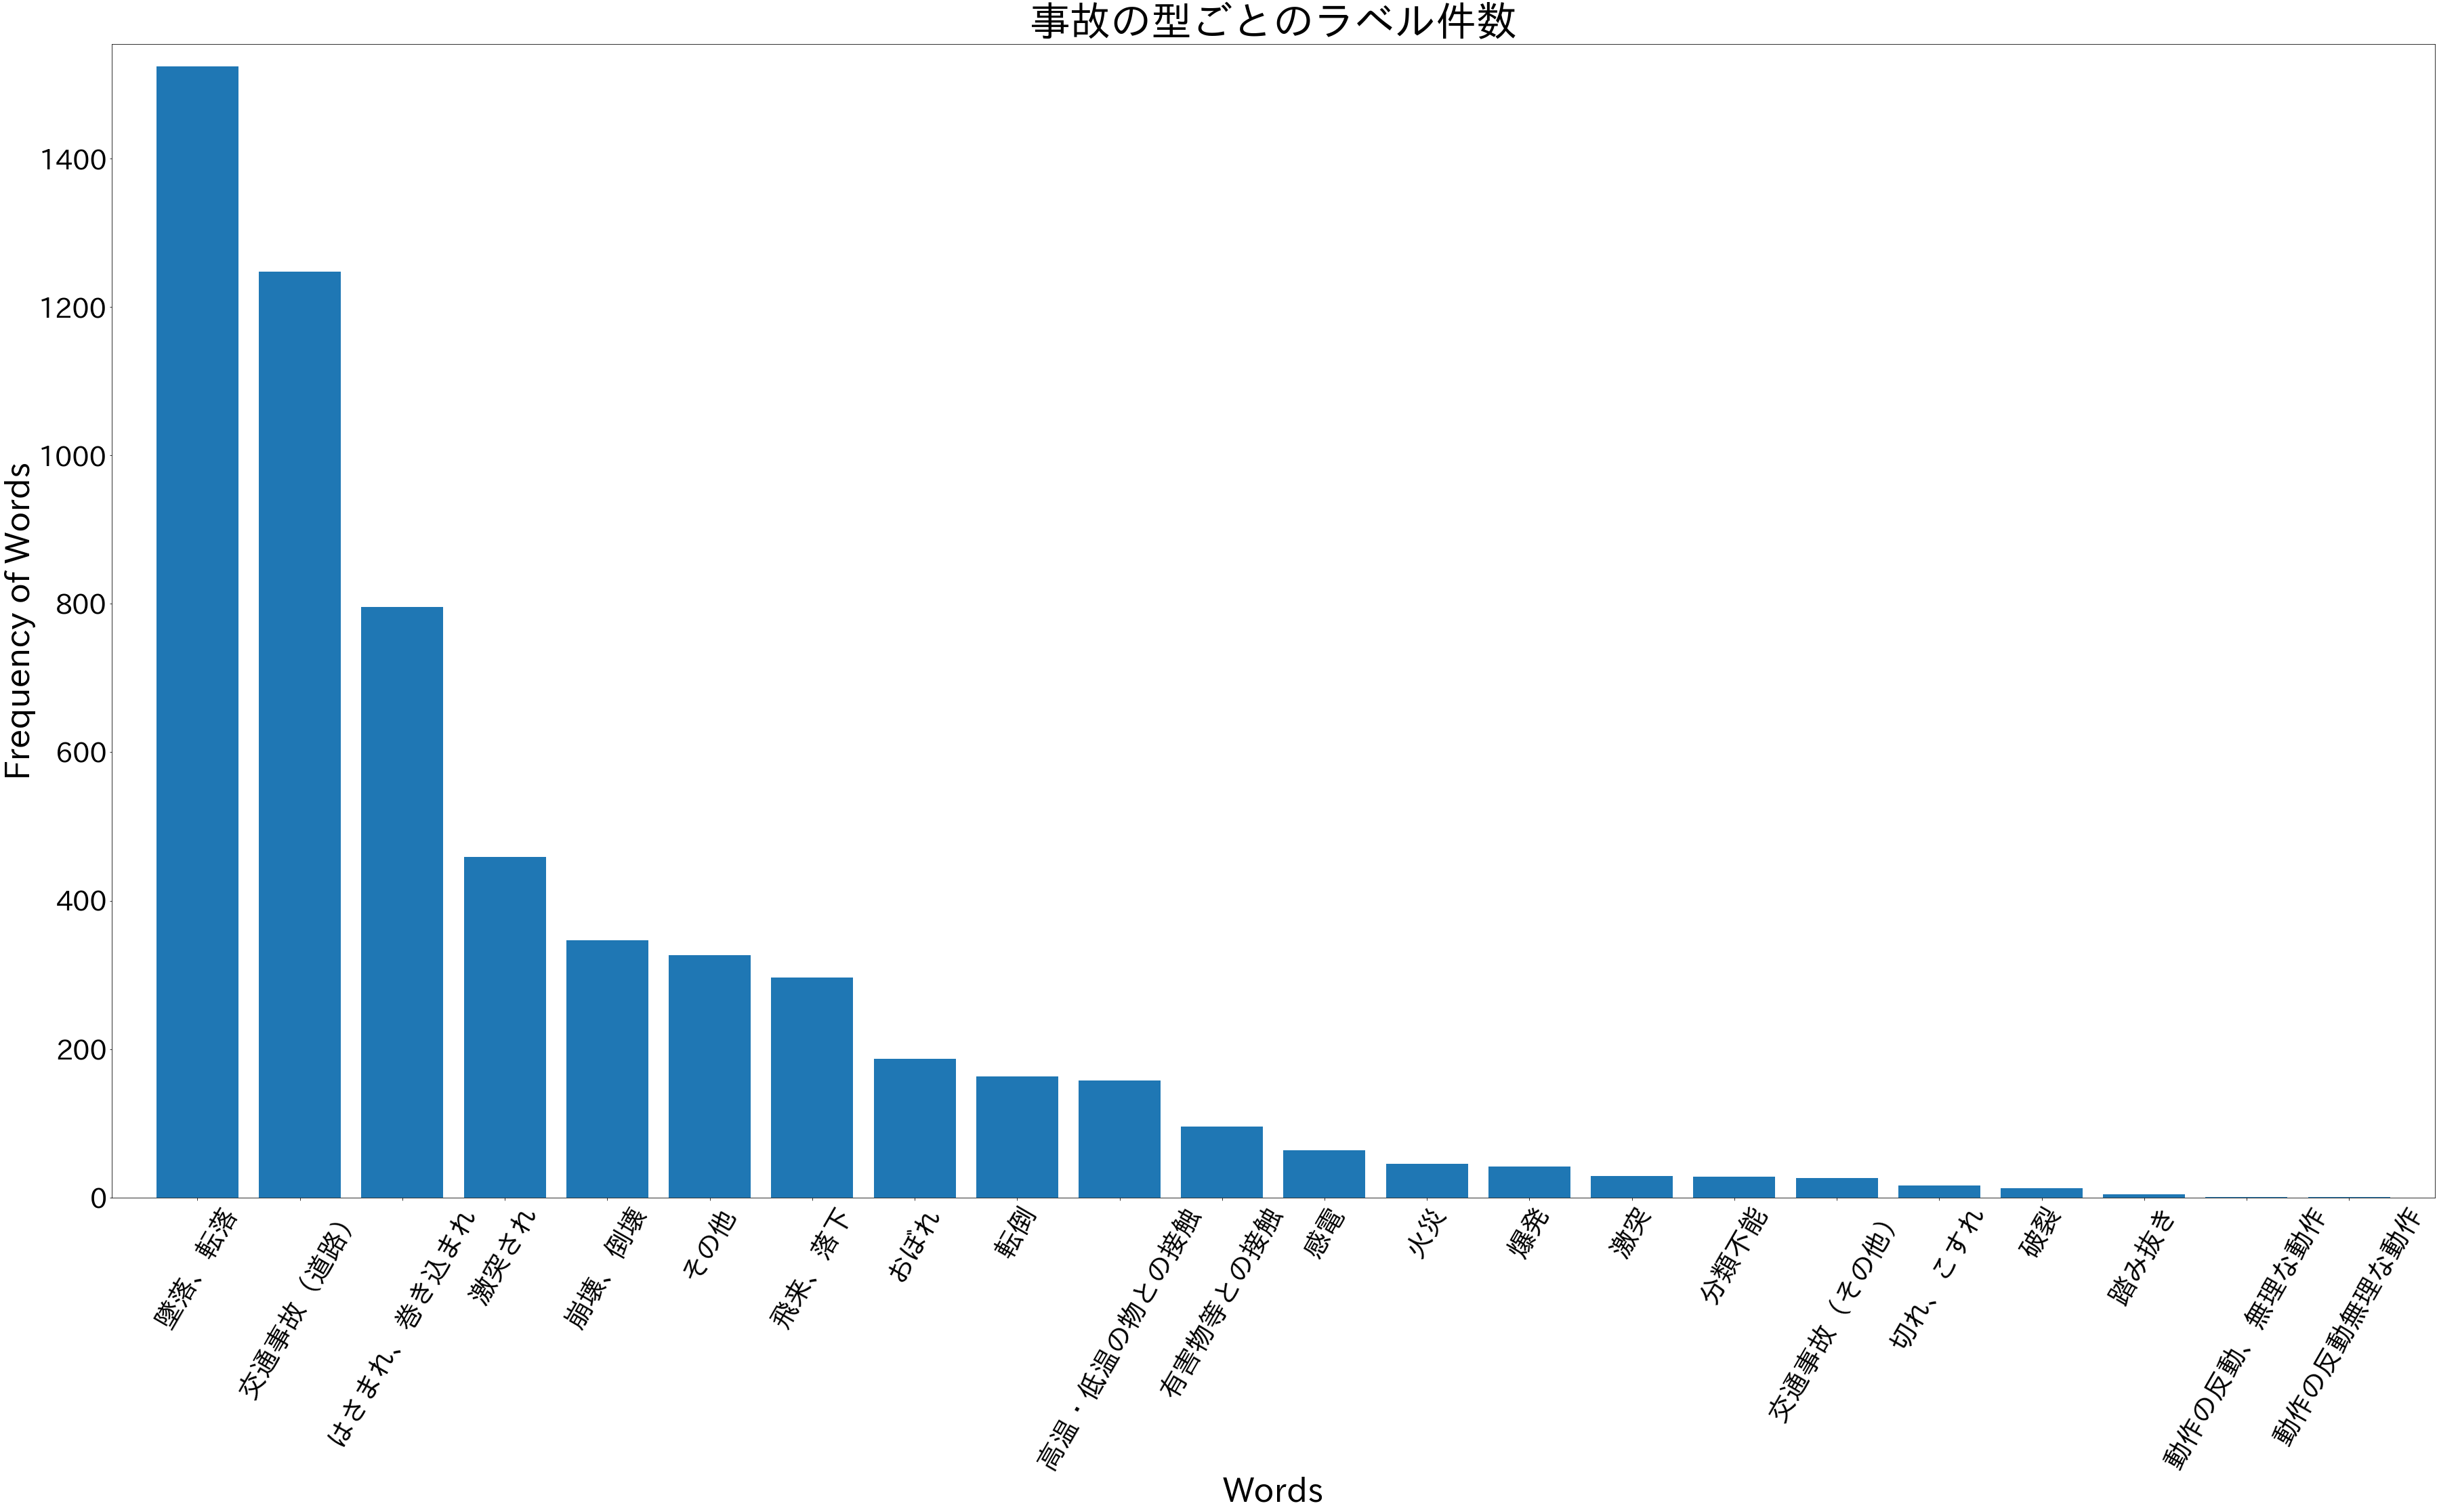

In [18]:
mostcommon_small = FreqDist(allwords).most_common(22)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('事故の型ごとのラベル件数', fontsize=60)
plt.show()

ここからが学習データでのファインチューニングを行う。

In [19]:
# Huggingface Transformersのインストール
!git clone https://github.com/huggingface/transformers
%cd transformers
!pip install .

Cloning into 'transformers'...
remote: Enumerating objects: 76923, done.
remote: Counting objects: 100% (1245/1245), done.
remote: Compressing objects: 100% (597/597), done.
remote: Total 76923 (delta 748), reused 969 (delta 557), pack-reused 75678
Receiving objects: 100% (76923/76923), 59.58 MiB | 28.51 MiB/s, done.
Resolving deltas: 100% (54774/54774), done.
/content/transformers
Processing /content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 901kB 8.0MB/s 
     |████████████████████████████████| 3.3MB 52.4MB/s 
  Created wheel for transformers: filename=transformers-4.9.0.dev0-cp37-none-any.whl size=2534231 sha256=8439a2bdc420c66997ce3e5cbce57c5bfdb3d7e7086805e9ab786e8eec8cc9f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-zjrfxd1b/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers


In [20]:
!pip install fugashi[unidic-lite]
!pip install ipadic

     |████████████████████████████████| 491kB 8.1MB/s 
     |████████████████████████████████| 47.4MB 86kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-cp37-none-any.whl size=47658838 sha256=1986823ba26ce07ece09967c834a225031c7041536ec02fea5560e447f6df4d3
  Stored in directory: /root/.cache/pip/wheels/20/48/8d/b66d8361a27f58f41ec86640e4fd2640de0403a6367511eab7
Successfully built unidic-lite
     |████████████████████████████████| 13.4MB 8.3MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-cp37-none-any.whl size=13556725 sha256=49b7942d612297c5e62fe9a760c2f18417fee83d32c5d609ea6b4dd7bdaa5496
  Stored in directory: /root/.cache/pip/wheels/ff/00/d1/0c094a0ce58a77199a0c5801f0ecf510c80f0ecbec27f07d2c
Successfully built ipadic


In [21]:
# Huggingface Datasetsのインストール
!pip install datasets

     |████████████████████████████████| 245kB 8.1MB/s 
     |████████████████████████████████| 245kB 39.9MB/s 
     |████████████████████████████████| 122kB 57.7MB/s 


In [22]:
train_csv = pd.read_csv('../train.csv')
train_csv.head()

,label,sentence
0,7,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1,17,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2,1,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3,1,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4,1,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...


学習の実行。データのうち8割（4696件）を学習データ。残りの2割（1174件）を評価用データとした。

In [41]:
%%time

# テキスト分類の学習
!python /content/transformers/examples/pytorch/text-classification/run_glue.py \
    --model_name_or_path=cl-tohoku/bert-base-japanese-whole-word-masking \
    --do_train \
    --do_eval \
    --max_seq_length=128 \
    --per_device_train_batch_size=32 \
    --use_fast_tokenizer=False \
    --learning_rate=1e-5 \
    --num_train_epochs=10 \
    --output_dir=output/ \
    --overwrite_output_dir \
    --train_file=../train.csv \
    --validation_file=../dev.csv  

2021-07-01 18:11:58.192342: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
07/01/2021 18:11:59 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
07/01/2021 18:11:59 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=500,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
greater_is_better=None,
group_by_length=False,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=1e-05,
length_co

学習の結果として検証データに対する精度は82.28%となった。
試しに未知のデータである、令和3年の労災事例のテキストを与えて実際に推論させてみる。

墜落事例
https://anzeninfo.mhlw.go.jp/anzen_pg/SAI_DET.aspx?joho_no=101610

In [39]:
import torch
from transformers import BertJapaneseTokenizer, AutoModelForSequenceClassification

# 入力テキスト
text =r""" 
被災者が、移動式クレーンに取り付けた搭乗設備（高さ約10メートル）に乗って、伐木予定のヒノキの枝打ち作業を行っていた。休憩のために作業を中断し、地上に降りるため、被災者自ら移動式クレーンを操作してジブの格納を開始した際、バランスを崩し搭乗設備から地上に墜落した。被災者は病院に搬送されたが、その後死亡した。
　ジブを格納する際、先端に取り付けた搭乗設備の水平機構（搭乗設備の水平を保つ機能）が無効になっていた。そのため、ジブの格納開始と同時に搭乗設備が大きく揺れ、被災者の上半身が木の枝に当たり、体勢を崩し、墜落したものと考えられる。被災者は墜落制止用器具を装着していたが、フックは掛けられていなかった。
"""


# モデルとトークナイザーの準備
model = AutoModelForSequenceClassification.from_pretrained('output/')    
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking') 

# テンソルに変換
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])

# 推論の実行

model.eval()
with torch.no_grad():
   outputs = model(tokens_tensor)[0]
   print(torch.argmax(outputs))

tensor(0)


はさまれ、巻き込まれ事例
https://anzeninfo.mhlw.go.jp/anzen_pg/SAI_DET.aspx?joho_no=101611

In [40]:
import torch
from transformers import BertJapaneseTokenizer, AutoModelForSequenceClassification

# 入力テキスト
text =r""" 
会社内倉庫で棚卸の準備作業として、被災者は鉄製の電動移動式棚の間で在庫管理の仕事を行っていた。離れた場所にいた別の作業員は、被災者が棚の間で作業中であることに気付かず、棚を操作したため、被災者は退避を試みたが間に合わず、棚のフレームに頭部をはさまれた。被災者は病院に搬送されたが、間もなく死亡した。
　電動移動式棚の運転モードは、通常用の自動モードと異常時・保守点検用の手動モードの切り替え式であった。自動モードでは1つの棚の間が自動で全開になるが、手動モードでは、任意の棚を動かし、複数箇所の間を開けることができる。災害発生時、被災者は手動モードで棚を移動させ、棚の間で作業を行っており、その後、別の作業員は自動モードで棚の移動を行っている。
　安全装置は、棚の入り口で人や障害物を検知するセンサーと、棚の作動時のメロディー音があった。センサーは、作動前に棚の間に入っていた作業者や障害物は検知せず、作動が可能な仕組みだった。メロディー音は、手動モードの場合には鳴らない仕組みだった。
"""


# モデルとトークナイザーの準備
model = AutoModelForSequenceClassification.from_pretrained('output/')    
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking') 

# テンソルに変換
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])

# 推論の実行

model.eval()
with torch.no_grad():
   outputs = model(tokens_tensor)[0]
   print(torch.argmax(outputs))

tensor(6)


実行結果と事故の型の対応

0:墜落、転落

1:転倒

2:激突

3:飛来、落下

4:崩壊、倒壊

5:激突され

6:はさまれ、巻き込まれ

7:切れ、こすれ

8:踏み抜き

9:おぼれ

10:高温・低温の物との接触

11:有害物等との接触

12:感電

13:爆発

14:破裂

15:火災

16:交通事故（道路）

17:交通事故（その他）

18:動作の反動、無理な動作

89:その他

98:分類不能

